## Let's cluster stations using the information available

In [1]:
from numpy import *
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn


# clustering
from sklearn import metrics
from sklearn import cluster
import sys
sys.path.append("/Users/efandel/Desktop/iPython Tools")
from rtbpythonutils import *
%matplotlib inline

In [70]:
trip_data = pd.read_csv('/Users/efandel/Desktop/hubway_2011_07_through_2013_11/hubway_trips.csv')
station_data = pd.read_csv('/Users/efandel/Desktop/hubway_2011_07_through_2013_11/hubway_stations.csv')
#calculate the total starting rides, ending rides, and average starting trip duration

starting_stations = pd.DataFrame(trip_data.groupby(['strt_statn'],as_index=False)['seq_id'].count())
starting_stations = starting_stations.rename(columns={'strt_statn': 'id', 'seq_id': 'ride_starts'})
ending_stations = pd.DataFrame(trip_data.groupby(['end_statn'],as_index=False)['seq_id'].count())
ending_stations = ending_stations.rename(columns={'end_statn': 'id', 'seq_id': 'ride_ends'})
station_avg_duration = pd.DataFrame(trip_data.groupby(['strt_statn'],as_index=False)['duration'].mean())
station_avg_duration = station_avg_duration.rename(columns={'strt_statn':'id','duration':'avg_duration'})
station_avg_duration.avg_duration = station_avg_duration.avg_duration/60

station_data = station_data.merge(starting_stations,on='id',how='left')
station_data = station_data.merge(ending_stations,on='id',how='left')
station_data = station_data.merge(station_avg_duration,on='id',how='left')

#calculate the average number of rides per day (arriving + departing) for each station.
#Assumption here that all stations existed throughout the 430 days of this dataset. ie none were built midway through

station_data['total_rides'] = station_data['ride_starts'] + station_data['ride_ends']
station_data['avg_rides_per_day'] = station_data['total_rides']/430

#trip_data.dropna(inplace=True)

In [58]:
station_data.head()

,id,terminal,station,municipal,lat,lng,status,ride_starts,ride_ends,avg_duration,total_rides,avg_rides_per_day
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing,9734,9260,17.474473,18994,44.172093
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing,18058,17472,17.042617,35530,82.627907
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing,10630,11058,16.956649,21688,50.437209
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing,23322,22655,18.985006,45977,106.923256
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing,9163,8883,20.316026,18046,41.967442


### Let's cluster the stations based on 1) average # of rides per day and 2) average trip duration. This will give us a sense of high/medium/low usage stations which can be useful for predicting maintenance needs.

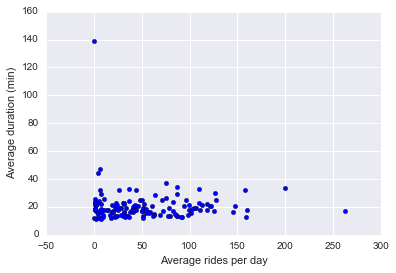

In [71]:
plt.scatter(station_data.avg_rides_per_day.values, station_data.avg_duration.values)
plt.xlabel('Average rides per day')
plt.ylabel('Average duration (min)')

### Remove the top left outlier and separate into 3 clusters using K means

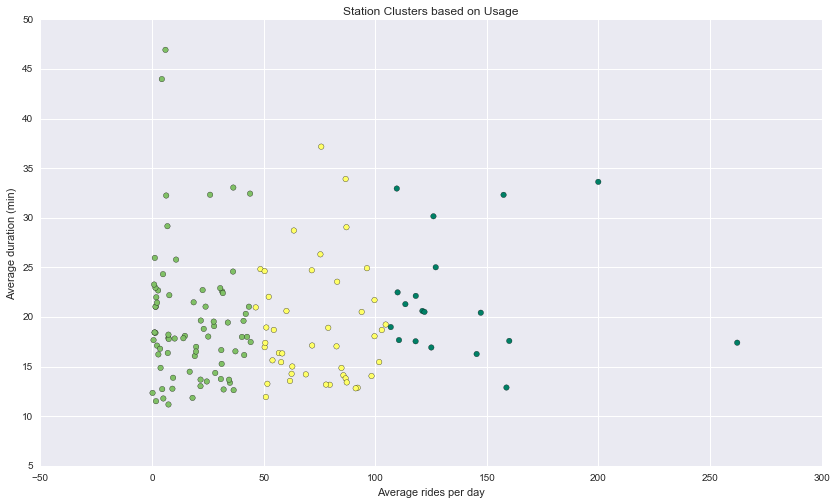

In [75]:
station_data = station_data[station_data['id'] != 108]

cls = cluster.k_means(station_data[ ['avg_rides_per_day', 'avg_duration'] ].values, 3)

station_data['clusters'] = cls[1]

cm = plt.cm.get_cmap('summer')

fig = plt.figure(figsize=(14,8))

plt.scatter(station_data.avg_rides_per_day.values, station_data.avg_duration.values, c=list(station_data.clusters.values),cmap = cm,s = 30)
plt.title('Station Clusters based on Usage')
plt.xlabel('Average rides per day')
plt.ylabel('Average duration (min)')
plt.show()

In [78]:
station_data.groupby(['clusters'])['avg_rides_per_day'].mean().sort_values(ascending=False)

clusters
0    138.902081
2     73.527907
1     18.128330
Name: avg_rides_per_day, dtype: float64

#### ^ Looks like 0 = high usage, 2 = medium usage, 1 = low usage

In [81]:
print("High Usage Stations")
print station_data[station_data.clusters == 0].station

High Usage Stations
3                        Cambridge St. at Joy St.
13                   Back Bay / South End Station
17           Aquarium Station - 200 Atlantic Ave.
18                  Prudential Center / Belvidere
19              South Station - 700 Atlantic Ave.
29                          Kenmore Sq / Comm Ave
32       Boston Public Library - 700 Boylston St.
36                    Lewis Wharf - Atlantic Ave.
38                  Boylston St. at Arlington St.
39                     Rowes Wharf - Atlantic Ave
42                        Christian Science Plaza
43                       Cross St. at Hanover St.
44                             Post Office Square
48                       Newbury St / Hereford St
49                           Beacon St / Mass Ave
50                           Tremont St / West St
54    The Esplanade - Beacon St. at Arlington St.
63                   MIT at Mass Ave / Amherst St
70            Harvard Square at Mass Ave/ Dunster
Name: station, dtype: object


In [82]:
print("Medium Usage Stations")
print station_data[station_data.clusters == 2].station

Medium Usage Stations
1                            Tremont St. at Berkeley St.
2                     Northeastern U / North Parking Lot
6                          Agganis Arena - 925 Comm Ave.
7                          B.U. Central - 725 Comm. Ave.
8                               Longwood Ave / Binney St
9                        Ruggles Station / Columbus Ave.
11      HMS / HSPH - Ave. Louis Pasteur at Longwood Ave.
14     Harvard University Housing - 111 Western Ave. ...
20            Mayor Thomas M. Menino - Government Center
21        Seaport Square - Seaport Blvd. at Boston Wharf
22                              Tremont St / W Newton St
23                         Washington St. at Waltham St.
26                          Brigham Cir / Huntington Ave
27                                         Seaport Hotel
28                                       Landmark Centre
34                               TD Garden - Legends Way
35                         Washington St. at Rutland St.
37       

In [83]:
print("Low Usage Stations")
print station_data[station_data.clusters == 1].station

Low Usage Stations
0                                 Colleges of the Fenway
4                                               Fan Pier
5          Union Square - Brighton Ave. at Cambridge St.
10                Boston Medical Center - 721 Mass. Ave.
12     Harvard Real Estate - Brighton Mills - 370 Wes...
15     Harvard Real Estate - 219 Western Ave. at Nort...
16                                          Buswell Park
24                              Roxbury Crossing Station
25       Innovation Lab - 125 Western Ave. at Batten Way
30                          Overland St at Brookline Ave
31                                 Summer St. / Arch St.
33                            New Balance - 38 Guest St.
47                           Washington St. at Lenox St.
52                                         Dudley Square
57                                 Boylston at Fairfield
58                                 Longwood Ave/Riverway
59                      Dorchester Ave. at Gillette Park
61          

### Let's cluster on lat/long 

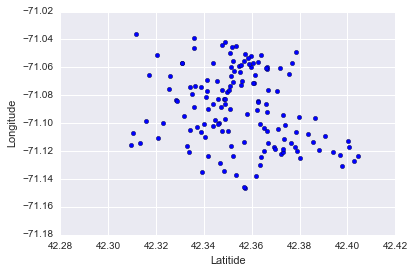

In [85]:
plt.scatter(station_data.lat.values, station_data.lng.values)
plt.xlabel('Latitide')
plt.ylabel('Longitude')

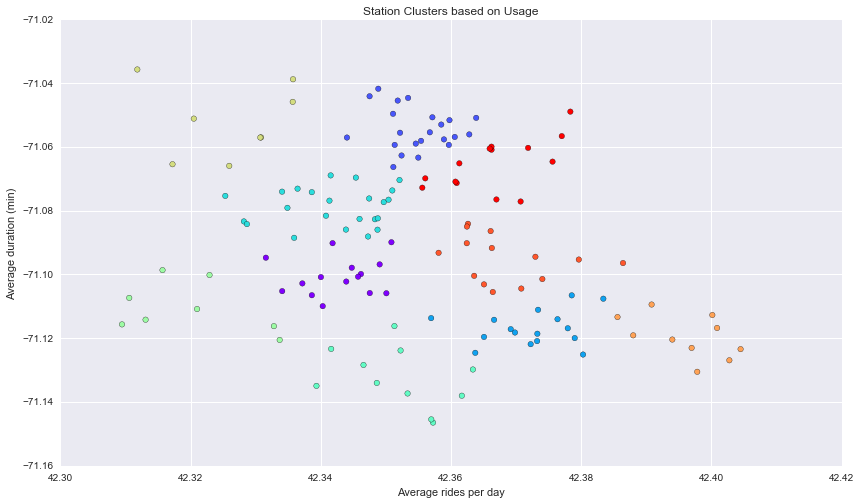

In [94]:
cls = cluster.k_means(station_data[ ['lat', 'lng'] ].values, 10)

station_data['clusters'] = cls[1]

cm = plt.cm.get_cmap('rainbow')

fig = plt.figure(figsize=(14,8))

plt.scatter(station_data.lat.values, station_data.lng.values, c=list(station_data.clusters.values),cmap = cm,s = 30)
plt.title('Station Clusters based on Usage')
plt.xlabel('Average rides per day')
plt.ylabel('Average duration (min)')
plt.show()

In [93]:
station_data[station_data.clusters==9].station

63                          MIT at Mass Ave / Amherst St
64                 Central Square at Mass Ave / Essex St
68         One Broadway / Kendall Sq at Main St / 3rd St
71     Lafayette Square at Mass Ave / Main St / Colum...
72     Central Sq Post Office / Cambridge City Hall a...
73                                  Somerville City Hall
74                             Union Square - Somerville
76               MIT Stata Center at Vassar St / Main St
84         Inman Square at Vellucci Plaza / Hampshire St
87      One Kendall Square at Hampshire St / Portland St
91           Cambridge St - at Columbia St / Webster Ave
124                                 Kendall T at Main St
131            359 Broadway - Broadway at Fayette Street
132                   Biogen Idec - Binney St / Sixth St
Name: station, dtype: object

### ^ Cambridge cluster!